<a href="https://colab.research.google.com/github/TatanPerez/Teoria_Aprendizaje_Maquina/blob/main/Talleres/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


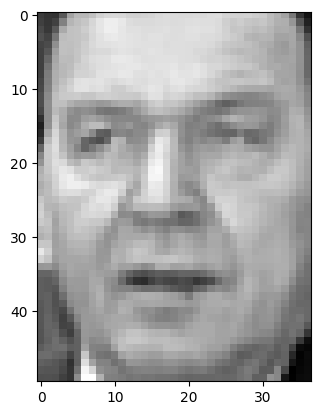

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # Added import
from sklearn.neighbors import KNeighborsClassifier # Added import
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
       [('nor',MinMaxScaler()),
        ('cla', SVC())],  #Pipeline3
       [('nor', MinMaxScaler()),
        ('cla', GaussianNB())], #Pipeline4
       [('nor', MinMaxScaler()),
        ('cla', LinearDiscriminantAnalysis())], #Pipeline5
       [("nor", MinMaxScaler()),
        ('cla', KNeighborsClassifier())], #Pipeline6
       [('nor', MinMaxScaler()),
        ('cla', LinearSVC(max_iter=10000))],  # Pipeline7
       [('nor', MinMaxScaler()),
        ('cla', SVC(kernel='linear'))],       # Pipeline8
       [('nor', MinMaxScaler()),
        ('cla', RandomForestClassifier())]    # Pipeline9
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
              'cla__C': [1,10,1e2,1e3,1e4],
              'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline3 - hyperparametros
             },
              {
               #Pipeline4
              },
              {
               'cla__solver': ['svd', 'lsqr'] #Pipeline5
              },
              {
                "cla__n_neighbors": [1,2,3,4,5,6,7,8,9,10], #Pipeline6 - hyperparametros
                "cla__weights": ["uniform", "distance"]
              },
              {
                  'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],  # Pipeline7 - LinearSVC
              },
              {
                  'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3]   # Pipeline8 - SVC con kernel linear
              },
              {
                  'cla__n_estimators': [10, 50, 100, 200],  # Pipeline9 - RandomForestClassifier
                  'cla__max_depth': [None, 5, 10, 20],
                  'cla__min_samples_split': [2, 5, 10]
              }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf','MinMax_NB','MinMax_SDG',
                'MinMax_LDA',
                'MinMax_LinearSVC',
                'MinMax_SVClinear',
                'MinMax_RandomForest'
    ]

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

NameError: name 'LinearDiscriminantAnalysis' is not defined

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # Added import
from sklearn.neighbors import KNeighborsClassifier # Added import
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
       [('nor',MinMaxScaler()),
        ('cla', SVC())],  #Pipeline3
       [('nor', MinMaxScaler()),
        ('cla', GaussianNB())], #Pipeline4
       [('nor', MinMaxScaler()),
        ('cla', LinearDiscriminantAnalysis())], #Pipeline5
       [("nor", MinMaxScaler()),
        ('cla', KNeighborsClassifier())], #Pipeline6
       [('nor', MinMaxScaler()),
        ('cla', LinearSVC(max_iter=10000))],  # Pipeline7
       [('nor', MinMaxScaler()),
        ('cla', SVC(kernel='linear'))],       # Pipeline8
       [('nor', MinMaxScaler()),
        ('cla', RandomForestClassifier())]    # Pipeline9
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
              'cla__C': [1,10,1e2,1e3,1e4],
              'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline3 - hyperparametros
             },
              {
               #Pipeline4
              },
              {
               'cla__solver': ['svd', 'lsqr'] #Pipeline5
              },
              {
                "cla__n_neighbors": [1,2,3,4,5,6,7,8,9,10], #Pipeline6 - hyperparametros
                "cla__weights": ["uniform", "distance"]
              },
              {
                  'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],  # Pipeline7 - LinearSVC
              },
              {
                  'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3]   # Pipeline8 - SVC con kernel linear
              },
              {
                  'cla__n_estimators': [10, 50, 100, 200],  # Pipeline9 - RandomForestClassifier
                  'cla__max_depth': [None, 5, 10, 20],
                  'cla__min_samples_split': [2, 5, 10]
              }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf','MinMax_NB','MinMax_SDG', # Corrected label_models
                'MinMax_LDA',
                'MinMax_LinearSVC',
                'MinMax_SVClinear',
                'MinMax_RandomForest'
    ]

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/9
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/9
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/9
Fitting 5 folds for each of 25 candidates, totalling 125 fits
modelo 4/9
Fitting 5 folds for each of 1 candidates, totalling 5 fits
modelo 5/9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
modelo 6/9
Fitting 5 folds for each of 20 candidates, totalling 100 fits
modelo 7/9
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 8/9
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 9/9
Fitting 5 folds for each of 48 candidates, totalling 240 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.5527378759975445)

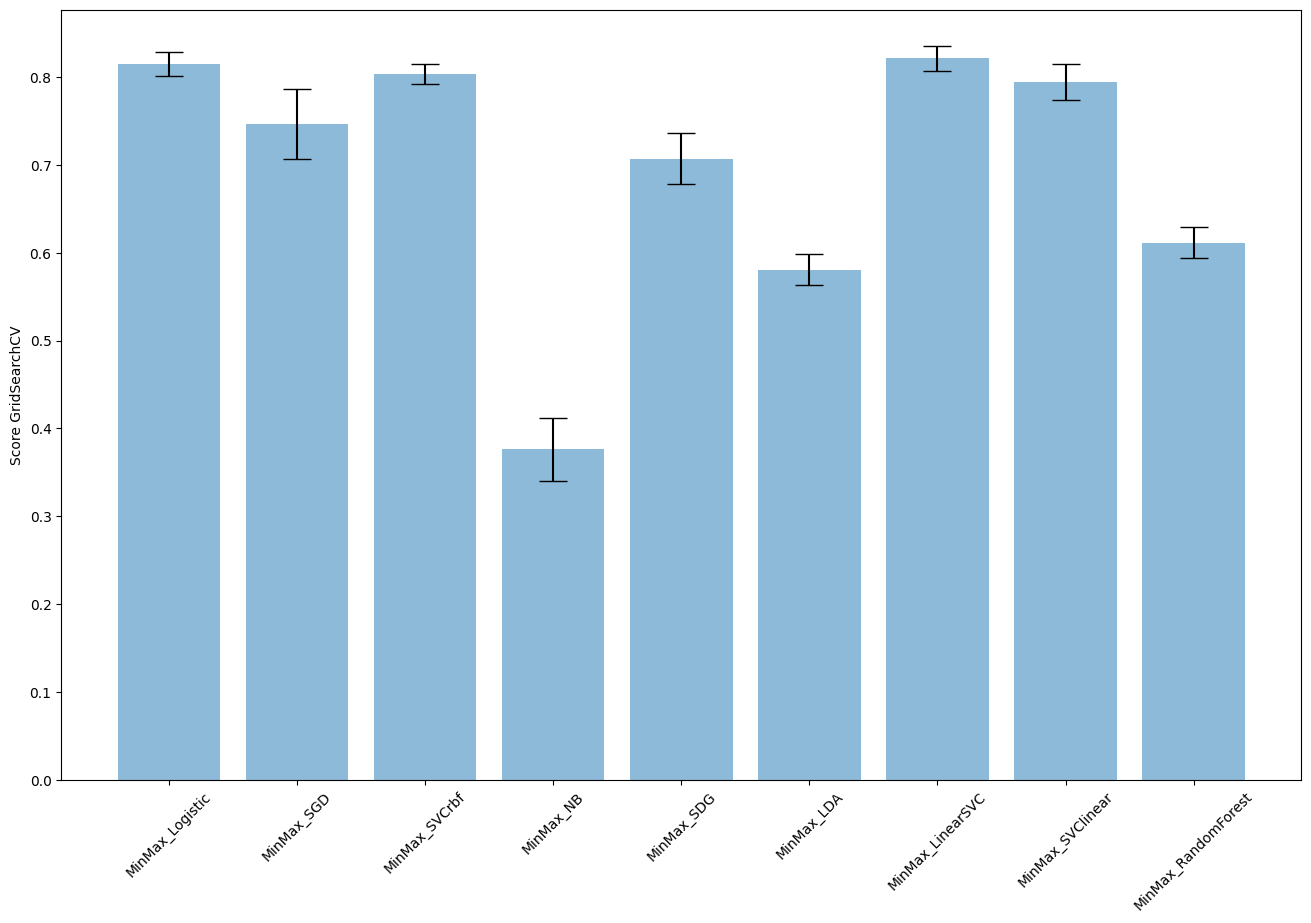

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_NB', 'MinMax_SDG', 'MinMax_LDA', 'MinMax_LinearSVC', 'MinMax_SVClinear', 'MinMax_RandomForest']
[[0.815 0.747 0.804 0.376 0.707 0.58  0.821 0.795 0.612]
 [0.014 0.04  0.011 0.036 0.029 0.018 0.014 0.021 0.017]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.figure(figsize=(16,10))
plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.xticks(rotation=45)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/9)


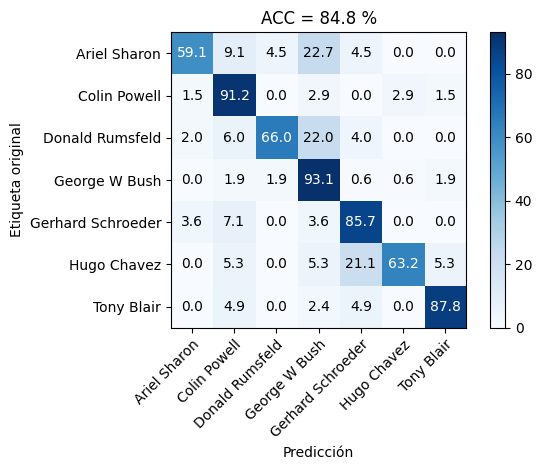

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/9)


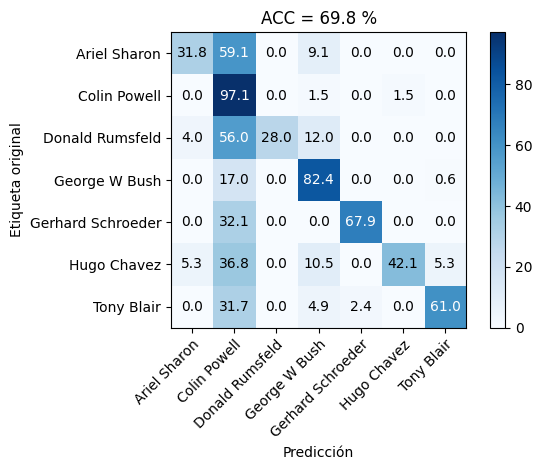

                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.32      0.44        22
     Colin Powell       0.40      0.97      0.57        68
  Donald Rumsfeld       1.00      0.28      0.44        50
    George W Bush       0.91      0.82      0.86       159
Gerhard Schroeder       0.95      0.68      0.79        28
      Hugo Chavez       0.89      0.42      0.57        19
       Tony Blair       0.93      0.61      0.74        41

         accuracy                           0.70       387
        macro avg       0.83      0.59      0.63       387
     weighted avg       0.82      0.70      0.70       387

Evaluando modelo MinMax_SVCrbf (3/9)


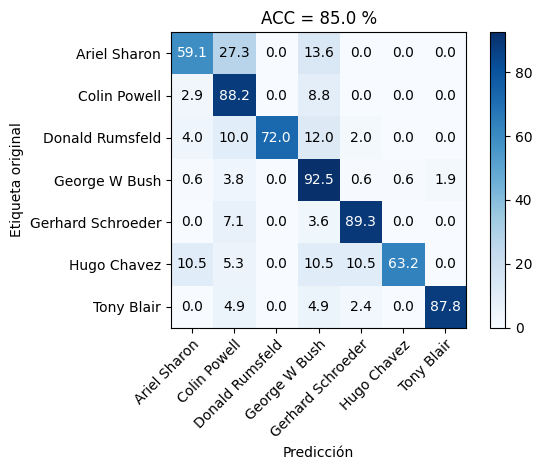

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387

Evaluando modelo MinMax_NB (4/9)


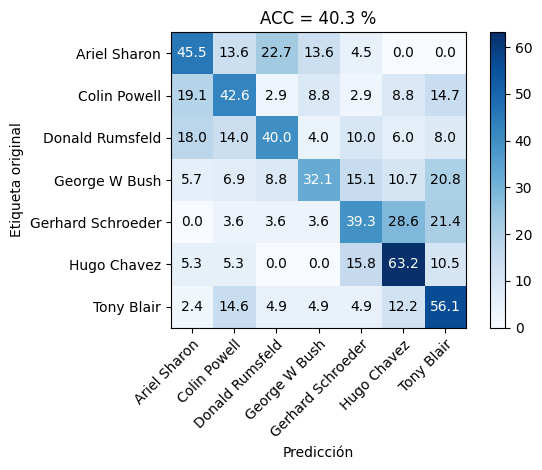

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo MinMax_SDG (5/9)


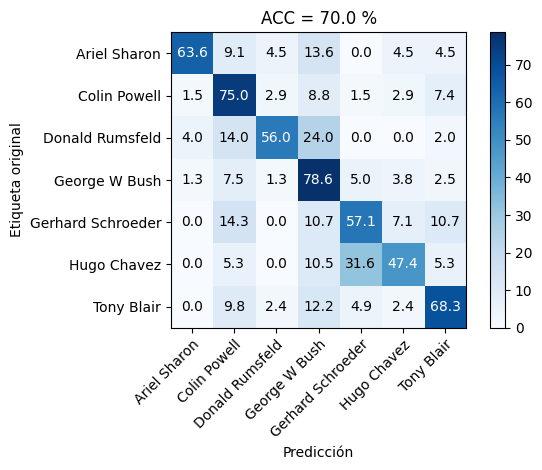

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluando modelo MinMax_LDA (6/9)


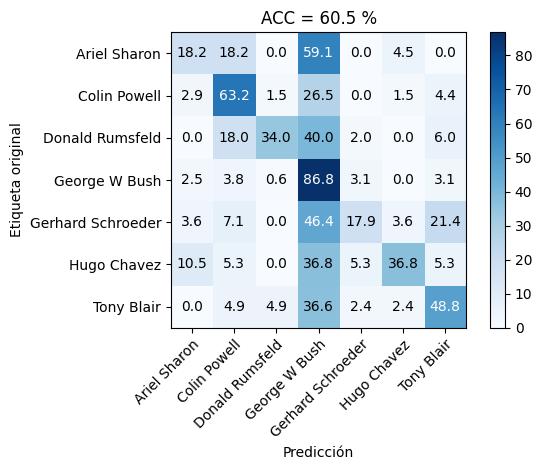

                   precision    recall  f1-score   support

     Ariel Sharon       0.31      0.18      0.23        22
     Colin Powell       0.64      0.63      0.64        68
  Donald Rumsfeld       0.81      0.34      0.48        50
    George W Bush       0.62      0.87      0.72       159
Gerhard Schroeder       0.38      0.18      0.24        28
      Hugo Chavez       0.64      0.37      0.47        19
       Tony Blair       0.53      0.49      0.51        41

         accuracy                           0.60       387
        macro avg       0.56      0.44      0.47       387
     weighted avg       0.60      0.60      0.58       387

Evaluando modelo MinMax_LinearSVC (7/9)


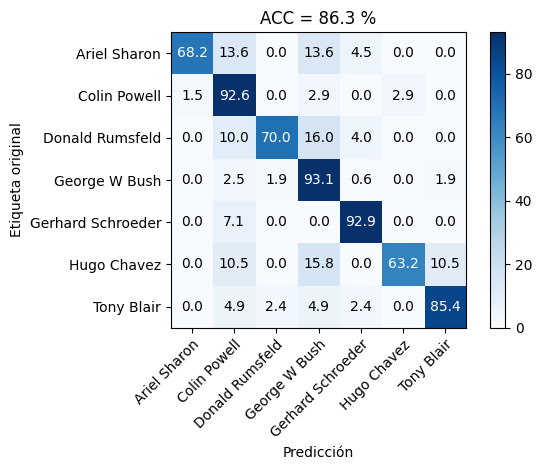

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.68      0.79        22
     Colin Powell       0.78      0.93      0.85        68
  Donald Rumsfeld       0.90      0.70      0.79        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.84      0.93      0.88        28
      Hugo Chavez       0.86      0.63      0.73        19
       Tony Blair       0.88      0.85      0.86        41

         accuracy                           0.86       387
        macro avg       0.87      0.81      0.83       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo MinMax_SVClinear (8/9)


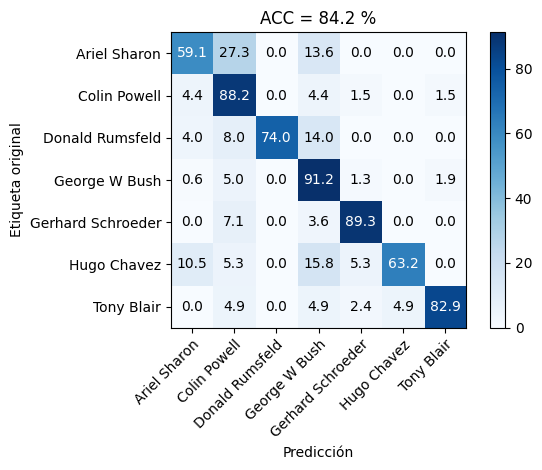

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.59      0.60        22
     Colin Powell       0.72      0.88      0.79        68
  Donald Rumsfeld       1.00      0.74      0.85        50
    George W Bush       0.88      0.91      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.86      0.63      0.73        19
       Tony Blair       0.89      0.83      0.86        41

         accuracy                           0.84       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.84      0.84       387

Evaluando modelo MinMax_RandomForest (9/9)


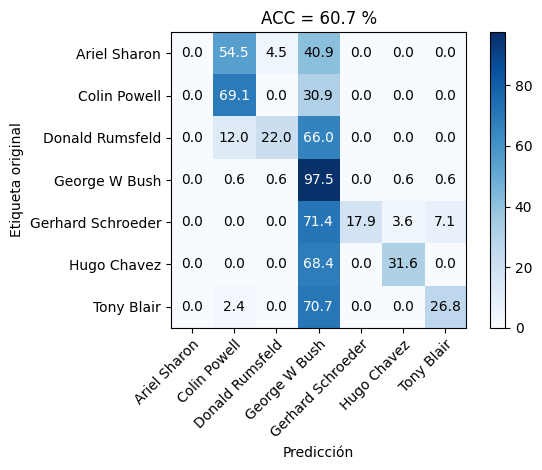

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.70      0.69      0.70        68
  Donald Rumsfeld       0.85      0.22      0.35        50
    George W Bush       0.55      0.97      0.71       159
Gerhard Schroeder       1.00      0.18      0.30        28
      Hugo Chavez       0.75      0.32      0.44        19
       Tony Blair       0.79      0.27      0.40        41

         accuracy                           0.61       387
        macro avg       0.66      0.38      0.41       387
     weighted avg       0.65      0.61      0.54       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/9)


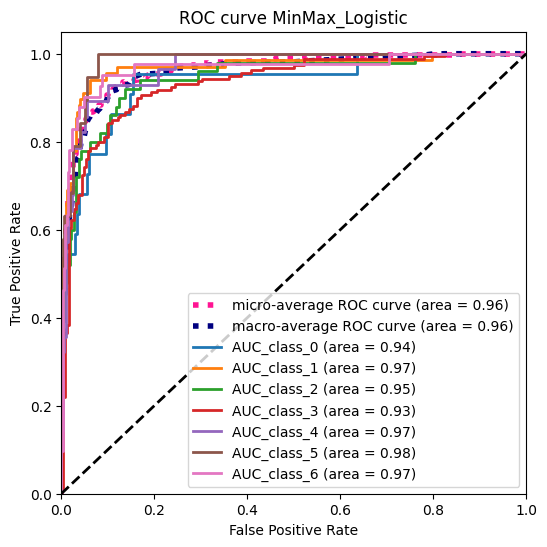

Evaluando modelo MinMax_SGD (2/9)


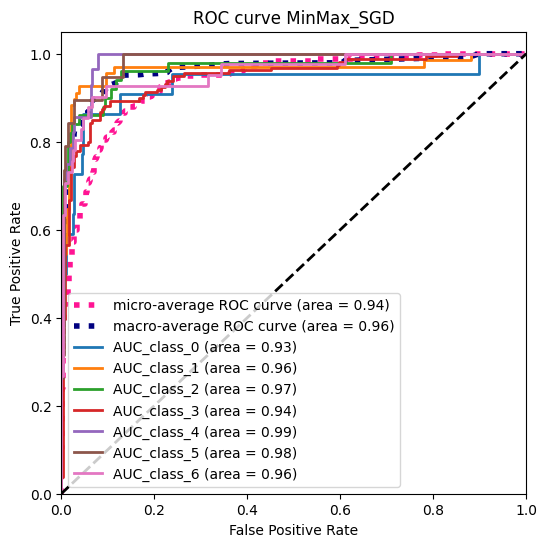

Evaluando modelo MinMax_SVCrbf (3/9)


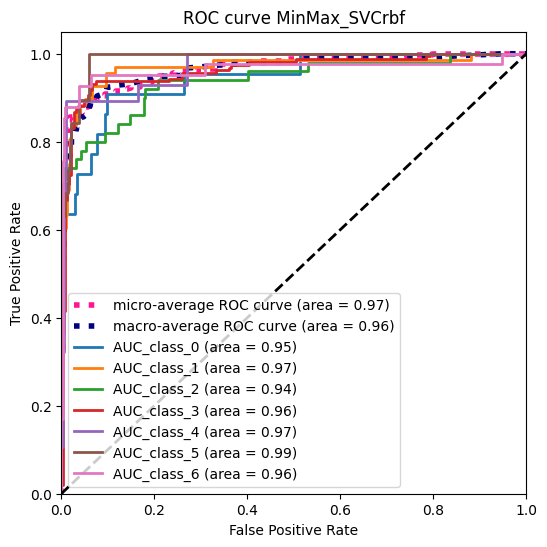

Evaluando modelo MinMax_NB (4/9)


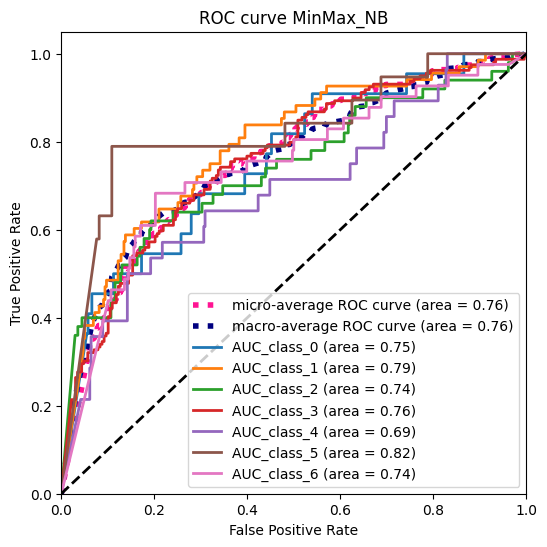

Evaluando modelo MinMax_SDG (5/9)


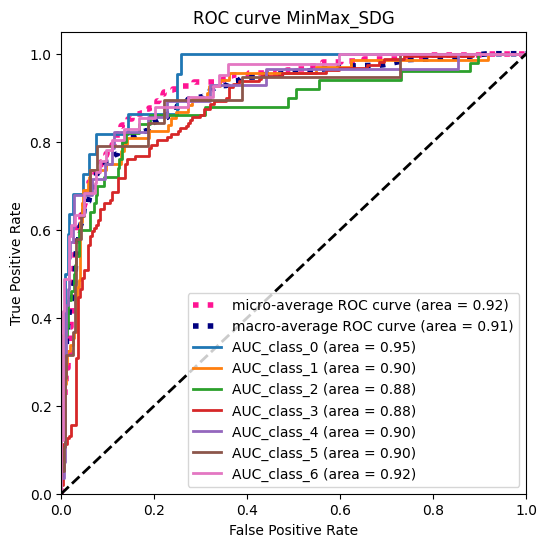

Evaluando modelo MinMax_LDA (6/9)


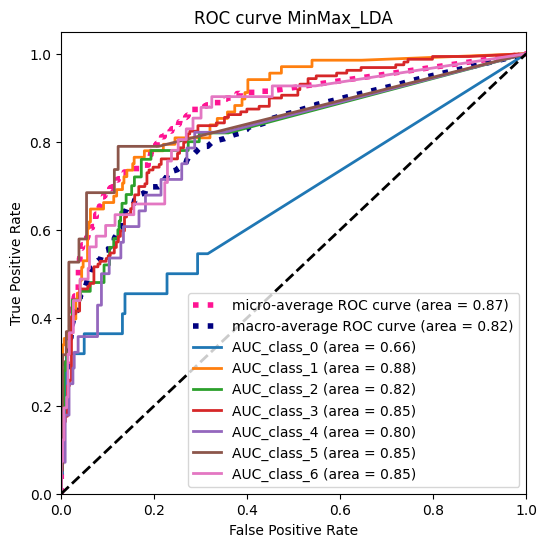

Evaluando modelo MinMax_LinearSVC (7/9)


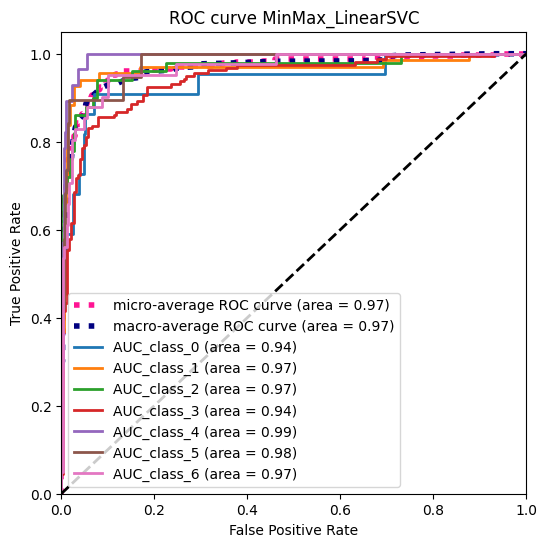

Evaluando modelo MinMax_SVClinear (8/9)


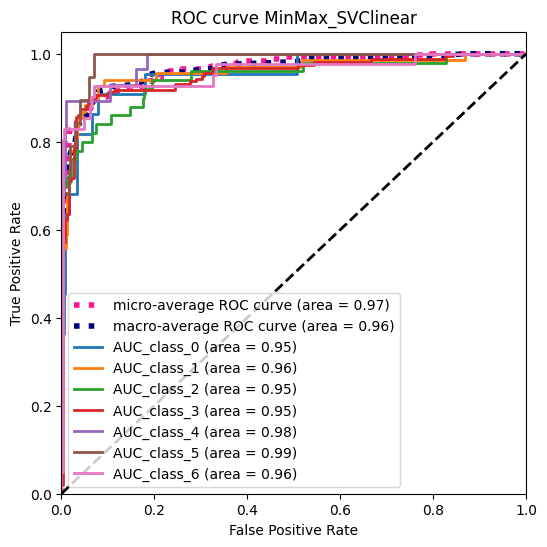

Evaluando modelo MinMax_RandomForest (9/9)


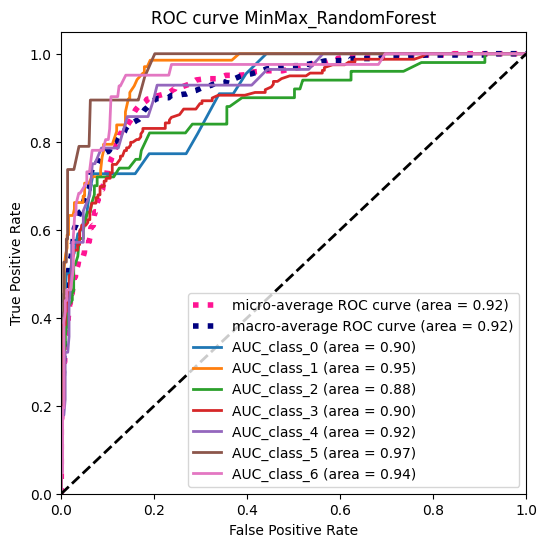

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np # Ensure numpy is imported
from sklearn.metrics import roc_curve, auc
import joblib # Ensure joblib is imported

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    # debe calcularse la funcion de decision o el posterior de la probabilidad
    # Check if the best estimator has decision_function, otherwise use predict_proba
    if hasattr(my_model_loaded[i].best_estimator_, 'decision_function'):
        ytest_score = my_model_loaded[i].decision_function(Xtest)
    elif hasattr(my_model_loaded[i].best_estimator_, 'predict_proba'):
        ytest_score = my_model_loaded[i].predict_proba(Xtest)
    else:
        # Handle cases where neither method is available, although unlikely for these models
        print(f"Model {label_models[i]} does not have decision_function or predict_proba.")
        continue # Skip to the next model

    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)

# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


# Modelos y Problemas de Optimización de Clasificadores

---

## 1. **Naive Bayes (GaussianNB)**
**Modelo**:  
Asume distribución gaussiana e independencia condicional:  
$$
P(y|x) \propto P(x|y) \cdot P(y), \quad \text{donde} \quad P(x|y) \sim \mathcal{N}(\mu_y, \sigma_y^2)
$$

**Optimización**:  
Estimación por máxima verosimilitud (MLE):  
$$
\mu_y = \frac{1}{n_y} \sum_{x \in \text{clase } y} x, \quad \sigma_y^2 = \frac{1}{n_y} \sum_{x \in \text{clase } y} (x - \mu_y)^2
$$

---

## 2. **SGDClassifier**
**Modelo**:  
Clasificador lineal con pérdida (logística/hinge).  

**Optimización**:  
$$
\min_w \left[ \frac{1}{n} \sum_{i=1}^n L(y_i, w^T x_i) + \alpha \|w\|^2 \right]
$$  
Ejemplo (pérdida logística):  
$$
L(y, z) = \log(1 + e^{-y z})
$$

---

## 3. **LogisticRegression**
**Modelo**:  
$$
P(y=1|x) = \frac{1}{1 + e^{-w^T x}}
$$

**Optimización**:  
$$
\min_w \left[ -\sum_{i=1}^n \left( y_i \log(\sigma(w^T x_i)) + (1 - y_i) \log(1 - \sigma(w^T x_i)) \right) + \alpha \|w\|^2 \right]
$$  
donde $\sigma(z) = \frac{1}{1 + e^{-z}}$.

---

## 4. **LinearDiscriminantAnalysis (LDA)**
**Modelo**:  
$$
\arg\max_y \left( x^T \Sigma^{-1} \mu_y - \frac{1}{2} \mu_y^T \Sigma^{-1} \mu_y + \log P(y) \right)
$$

**Optimización**:  
Estimación directa:  
$$
\mu_y = \frac{1}{n_y} \sum_{x \in y} x, \quad \Sigma = \frac{1}{n} \sum_y \sum_{x \in y} (x - \mu_y)(x - \mu_y)^T
$$

---

## 5. **KNeighborsClassifier**
**Modelo**:  
No paramétrico (basado en votos de los $k$ vecinos más cercanos).  

**Optimización**:  
No aplica (hiperparámetros: $k$ y métrica de distancia).

---

## 6. **LinearSVC**
**Modelo**:  
Hiperplano $w^T x + b = 0$ que maximiza el margen.  

**Optimización**:  
$$
\min_{w, b} \left[ \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \max(0, 1 - y_i (w^T x_i + b)) \right]
$$

---

## 7. **SVC (Kernel SVM)**
**Modelo**:  
Kernel (ej: RBF $K(x_i, x_j) = e^{-\gamma \|x_i - x_j\|^2}$).  

**Optimización (dual)**:  
$$
\max_{\alpha} \left[ \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j K(x_i, x_j) \right]
$$  
sujeto a:  
$$
0 \leq \alpha_i \leq C, \quad \sum_i \alpha_i y_i = 0
$$

---

## 8. **RandomForestClassifier**
**Modelo**:  
Ensemble de árboles con bagging.  

**Optimización**:  
Minimizar impureza (ej: Gini):  
$$
\text{Gini} = \sum_{i \in \text{nodo}} p_i (1 - p_i), \quad p_i = \text{proporción clase } i
$$

---

### **Resumen**  
| Tipo                | Clasificadores                          |
|---------------------|----------------------------------------|
| **Paramétricos**    | SGD, LogisticRegression, LinearSVC, SVC |
| **Estimación directa** | GaussianNB, LDA                     |
| **No paramétricos** | KNN, RandomForest                      |

In [ ]:
!pip install scikit-optimize


In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from skopt import BayesSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Carga del dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names

# División de datos
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Preprocesamiento: PCA + Escalado
pca = PCA(n_components=150, whiten=True, random_state=42)
scaler = StandardScaler()

# Validación cruzada
cv = StratifiedKFold(n_splits=5)

# Definición de modelos y espacios de búsqueda
models = {
    'GaussianNB': (GaussianNB(), {}),

    'SGDClassifier': (
        SGDClassifier(random_state=42),
        {
            'sgdclassifier__alpha': (1e-6, 1e-1, 'log-uniform'),
            'sgdclassifier__penalty': ['l2', 'l1'],
            'sgdclassifier__loss': ['hinge', 'log_loss']
        }
    ),

    'LogisticRegression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {
            'logisticregression__C': (1e-3, 1e+3, 'log-uniform'),
            'logisticregression__solver': ['liblinear']
        }
    ),

    'LinearDiscriminantAnalysis': (
        LinearDiscriminantAnalysis(),
        {
            'lineardiscriminantanalysis__solver': ['svd', 'lsqr']
        }
    ),

    'KNeighborsClassifier': (
        KNeighborsClassifier(),
        {
            'kneighborsclassifier__n_neighbors': (1, 10),
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    ),

    'LinearSVC': (
        LinearSVC(max_iter=5000, random_state=42),
        {
            'linearsvc__C': (1e-3, 1e+3, 'log-uniform')
        }
    ),

    'SVC': (
        SVC(probability=True, random_state=42),
        {
            'svc__C': (1e-3, 1e+3, 'log-uniform'),
            'svc__gamma': (1e-4, 1e-1, 'log-uniform'),
            'svc__kernel': ['rbf']
        }
    ),

    'RandomForestClassifier': (
        RandomForestClassifier(random_state=42),
        {
            'randomforestclassifier__n_estimators': (10, 200),
            'randomforestclassifier__max_depth': (5, 50)
        }
    )
}

results = []

for name, (model, search_space) in models.items():
    steps = [('scaler', scaler), ('pca', pca), (name.lower(), model)]
    pipe = Pipeline(steps)

    if search_space:
        opt = BayesSearchCV(pipe, search_spaces=search_space, n_iter=20, scoring='f1_weighted', cv=cv, n_jobs=-1, random_state=42)
    else:
        opt = pipe

    if isinstance(opt, BayesSearchCV):
        opt.fit(Xtrain, ytrain)
        best_model = opt.best_estimator_
    else:
        opt.fit(Xtrain, ytrain)
        best_model = opt

    ypred = best_model.predict(Xtest)
    yprob = best_model.predict_proba(Xtest) if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(ytest, ypred)
    f1 = f1_score(ytest, ypred, average='weighted')
    auc = roc_auc_score(ytest, yprob, multi_class='ovr', average='weighted') if yprob is not None else np.nan

    results.append({
        'Modelo': name,
        'Accuracy': acc,
        'F1_score': f1,
        'AUC': auc
    })

results_df = pd.DataFrame(results).sort_values(by='F1_score', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Modelo,Accuracy,F1_score,AUC
0,SVC,0.863354,0.859098,0.981404
1,LinearDiscriminantAnalysis,0.847826,0.844373,0.973541
2,LinearSVC,0.844720,0.838592,NaN
3,LogisticRegression,0.841615,0.834583,0.956132
4,SGDClassifier,0.791925,0.783531,NaN
5,KNeighborsClassifier,0.711180,0.699371,0.888636
6,GaussianNB,0.670807,0.662793,0.907645
7,RandomForestClassifier,0.586957,0.508289,0.886152


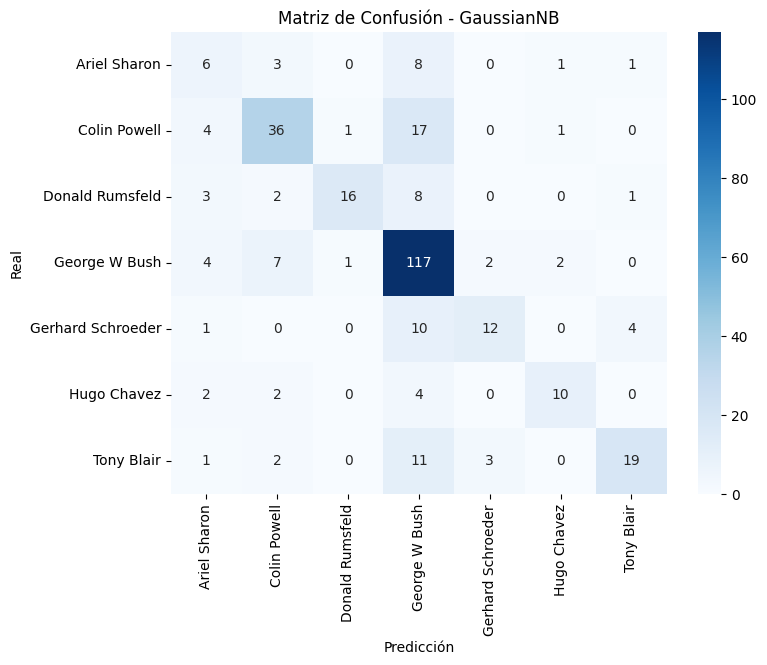

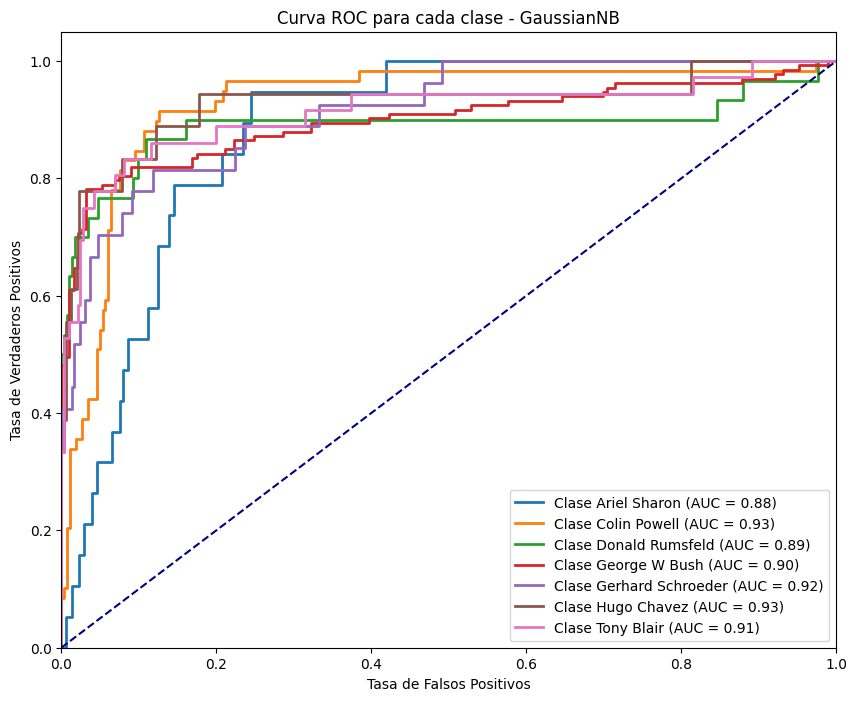

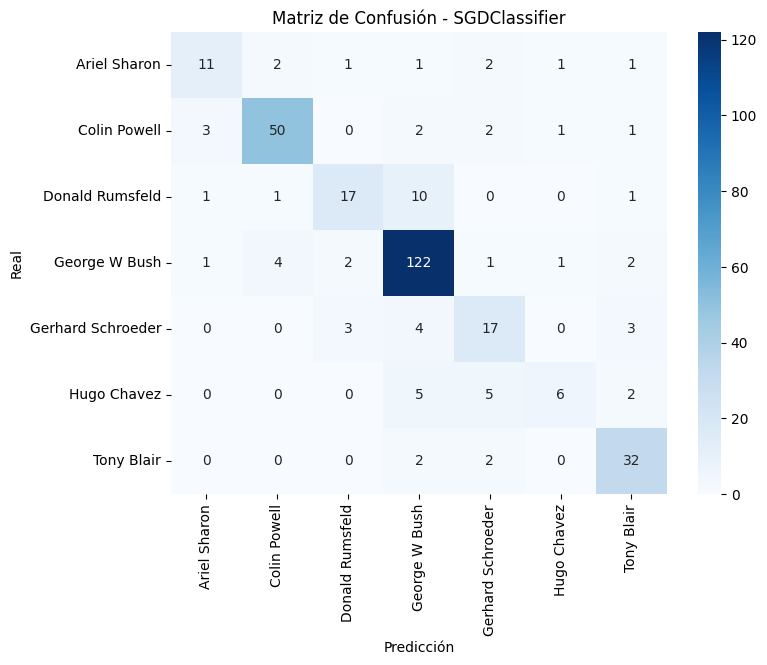

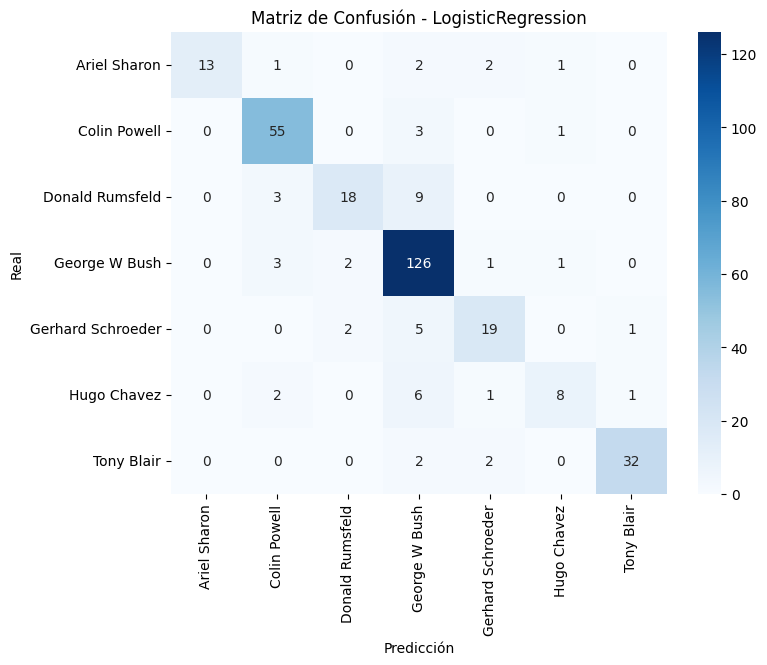

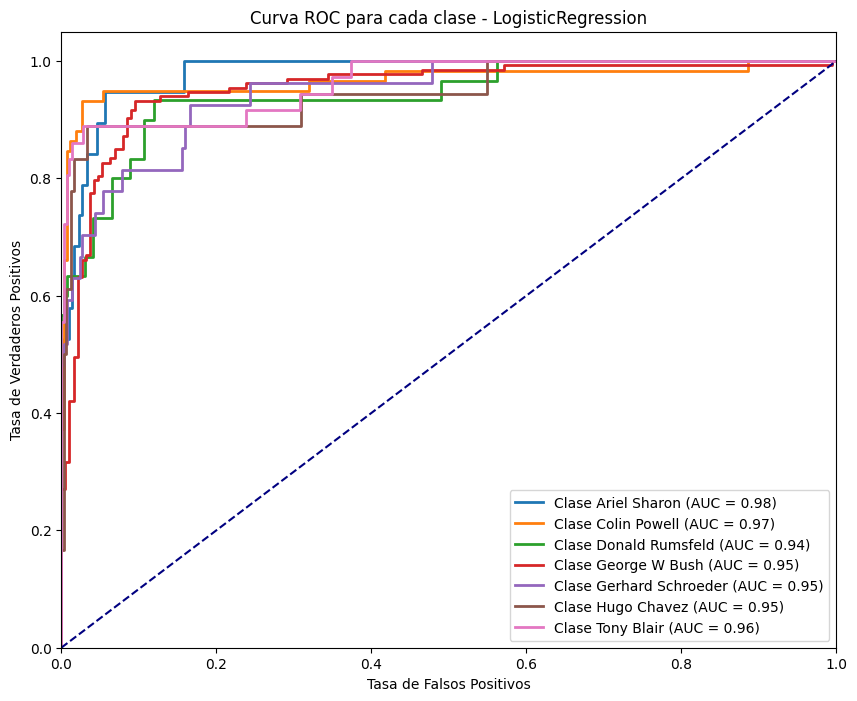

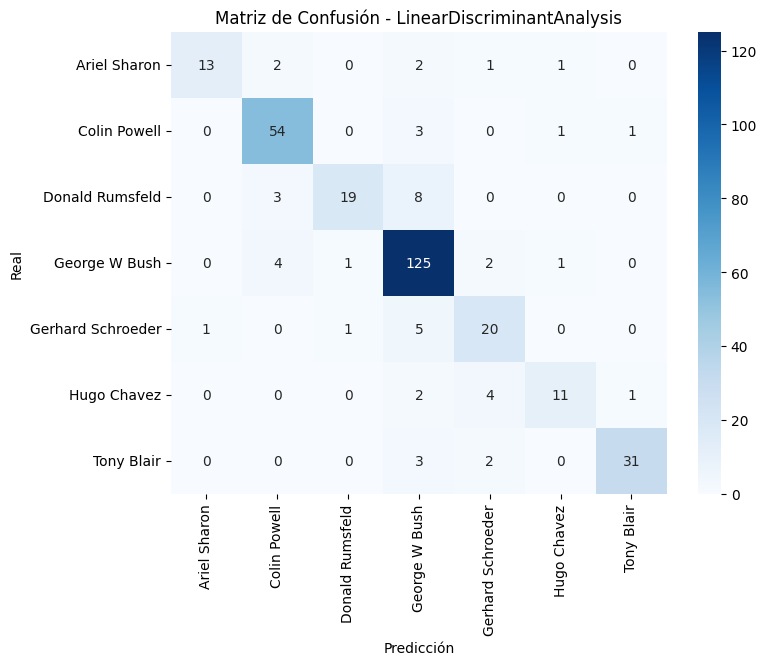

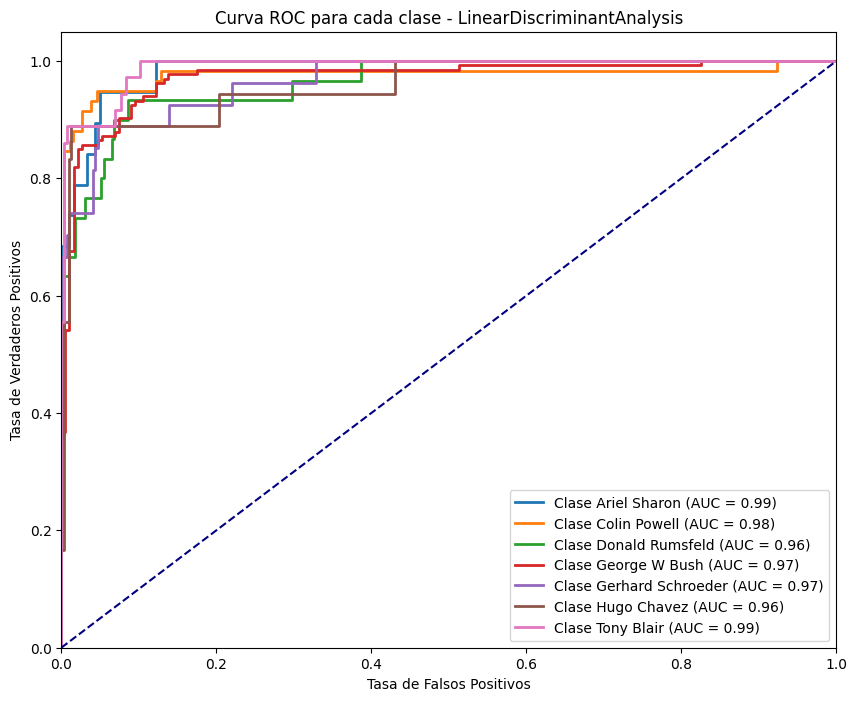

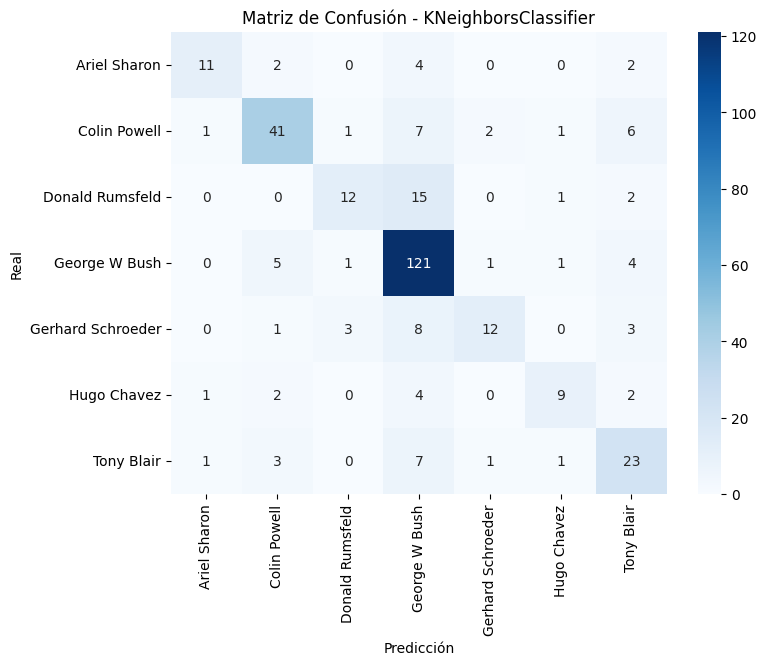

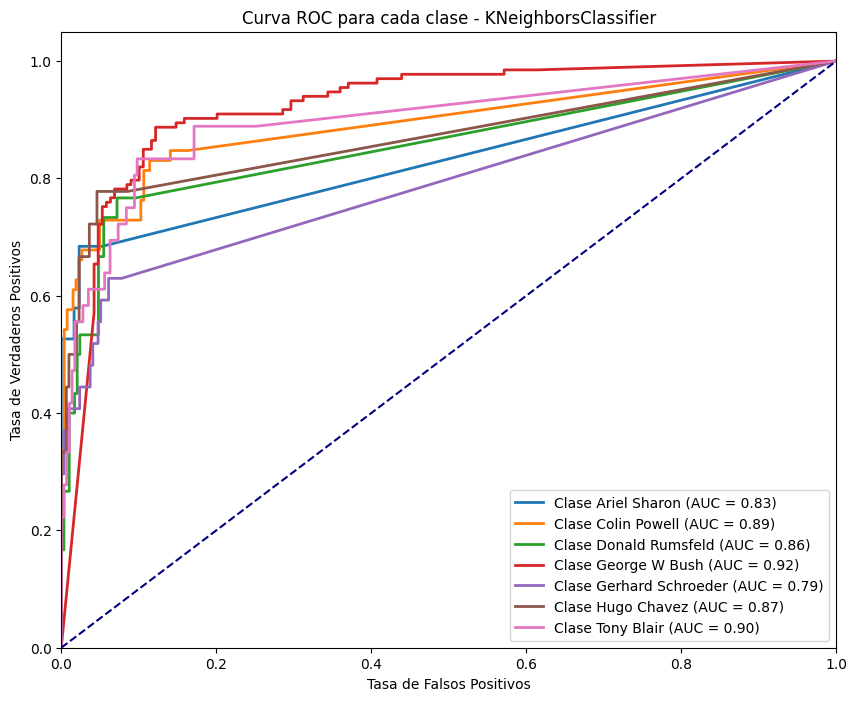

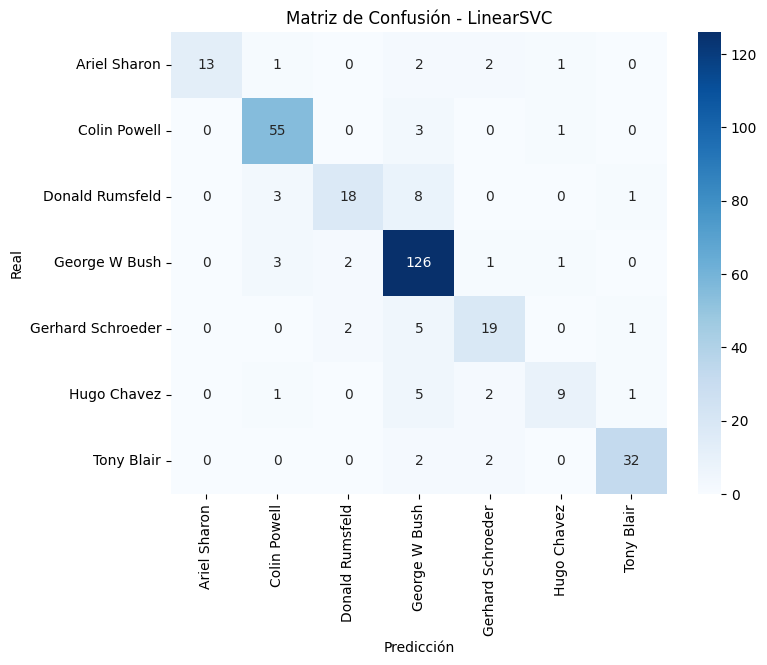

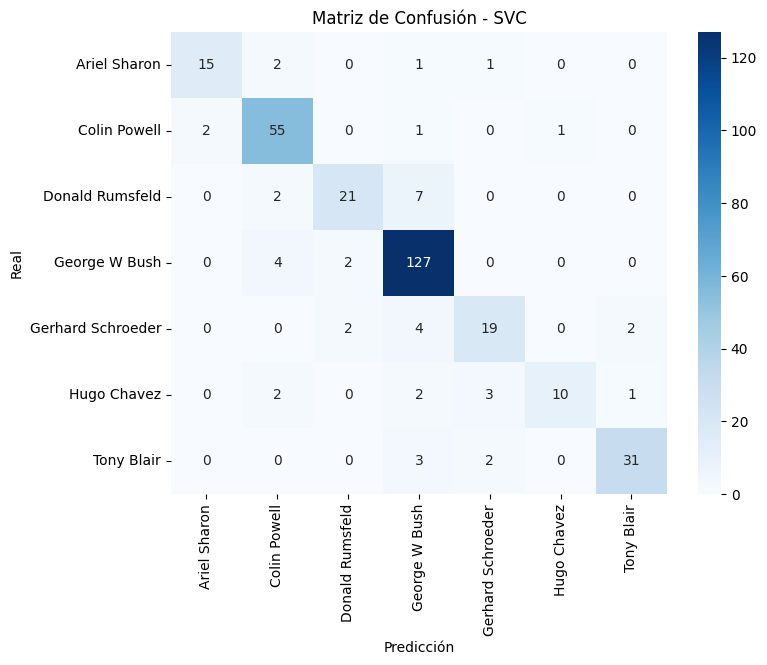

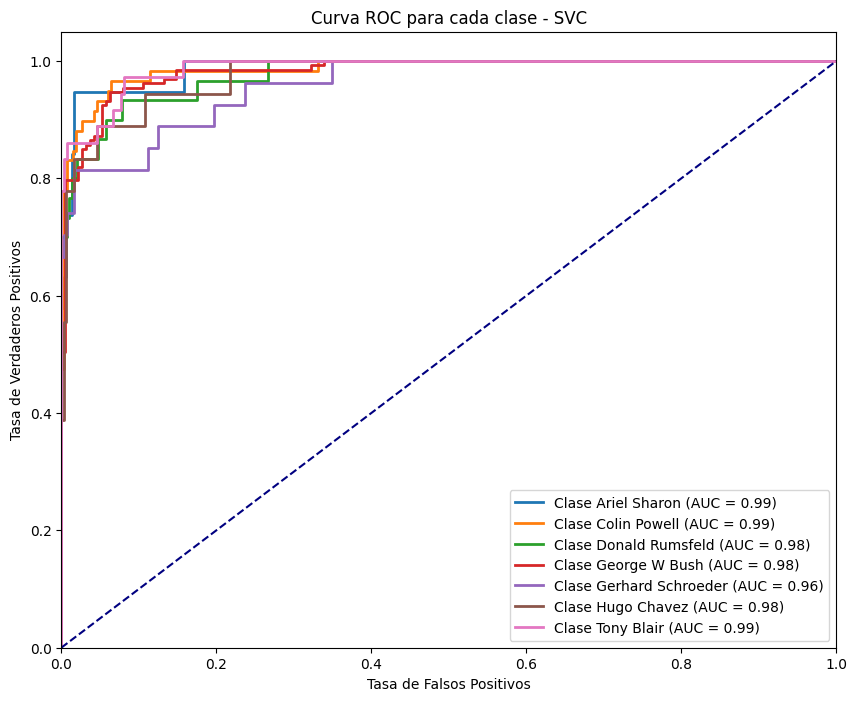

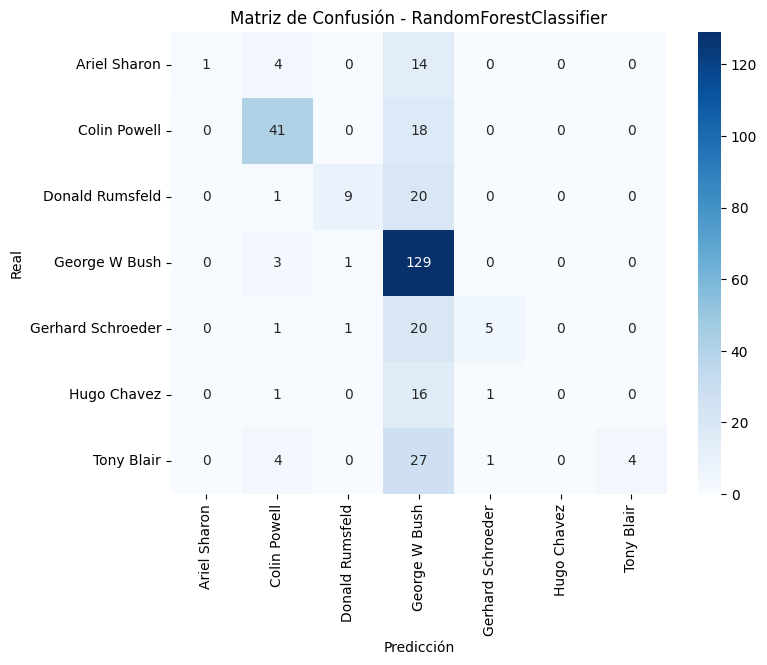

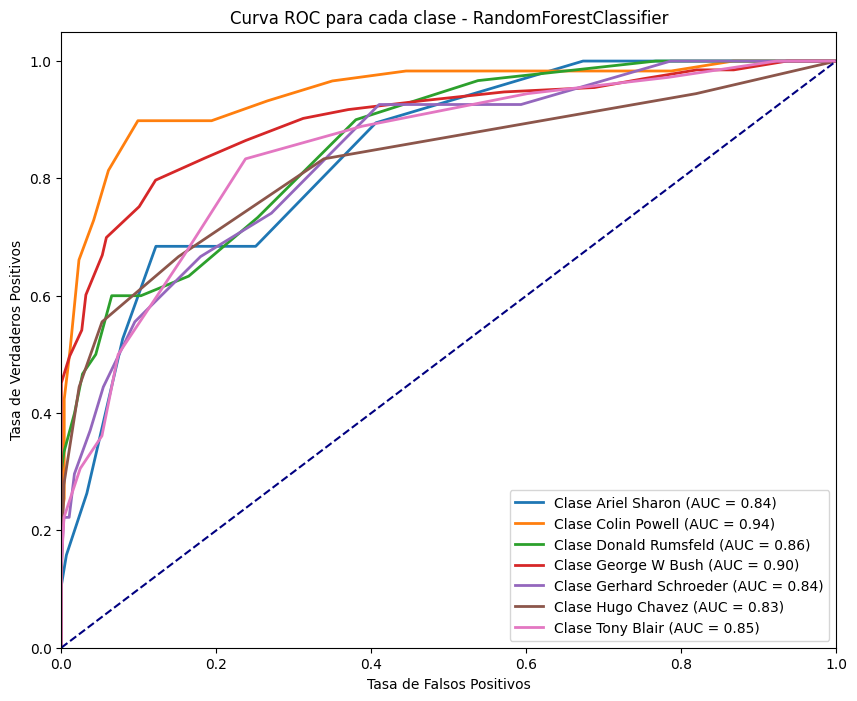

                       Modelo  Accuracy  F1_score       AUC
0                         SVC  0.863354  0.859098  0.981404
1  LinearDiscriminantAnalysis  0.847826  0.844373  0.973541
2                   LinearSVC  0.844720  0.838592       NaN
3          LogisticRegression  0.841615  0.834583  0.956132
4               SGDClassifier  0.791925  0.783531       NaN
5        KNeighborsClassifier  0.711180  0.699371  0.888636
6                  GaussianNB  0.670807  0.662793  0.907645
7      RandomForestClassifier  0.586957  0.508289  0.886152


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Vamos a suponer que `models` es el diccionario con tus modelos y `Xtrain`, `ytrain`, `Xtest`, `ytest`
results = []

for name, (model, search_space) in models.items():
    steps = [('scaler', scaler), ('pca', pca), (name.lower(), model)]
    pipe = Pipeline(steps)

    # Optimización Bayesiana si existe un espacio de búsqueda
    if search_space:
        opt = BayesSearchCV(pipe, search_spaces=search_space, n_iter=20, scoring='f1_weighted', cv=cv, n_jobs=-1, random_state=42)
    else:
        opt = pipe

    # Ajuste y predicción
    opt.fit(Xtrain, ytrain)
    best_model = opt.best_estimator_ if isinstance(opt, BayesSearchCV) else opt

    # Predicciones y probabilidades
    ypred = best_model.predict(Xtest)
    yprob = best_model.predict_proba(Xtest) if hasattr(best_model, "predict_proba") else None

    # Evaluar métricas
    acc = accuracy_score(ytest, ypred)
    f1 = f1_score(ytest, ypred, average='weighted')
    auc_score = roc_auc_score(ytest, yprob, multi_class='ovr', average='weighted') if yprob is not None else np.nan

    results.append({
        'Modelo': name,
        'Accuracy': acc,
        'F1_score': f1,
        'AUC': auc_score
    })

    # Matriz de confusión
    cm = confusion_matrix(ytest, ypred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # Curvas ROC
    if yprob is not None:
        # Binarizamos las etiquetas para cada clase (en caso de multiclase)
        ytest_bin = label_binarize(ytest, classes=np.unique(ytest))

        plt.figure(figsize=(10, 8))
        for i in range(ytest_bin.shape[1]):
            fpr, tpr, _ = roc_curve(ytest_bin[:, i], yprob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Clase {target_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC para cada clase - {name}')
        plt.legend(loc='lower right')
        plt.show()

# Al final, mostramos un dataframe con los resultados.
results_df = pd.DataFrame(results).sort_values(by='F1_score', ascending=False)
results_df.reset_index(drop=True, inplace=True)
print(results_df)


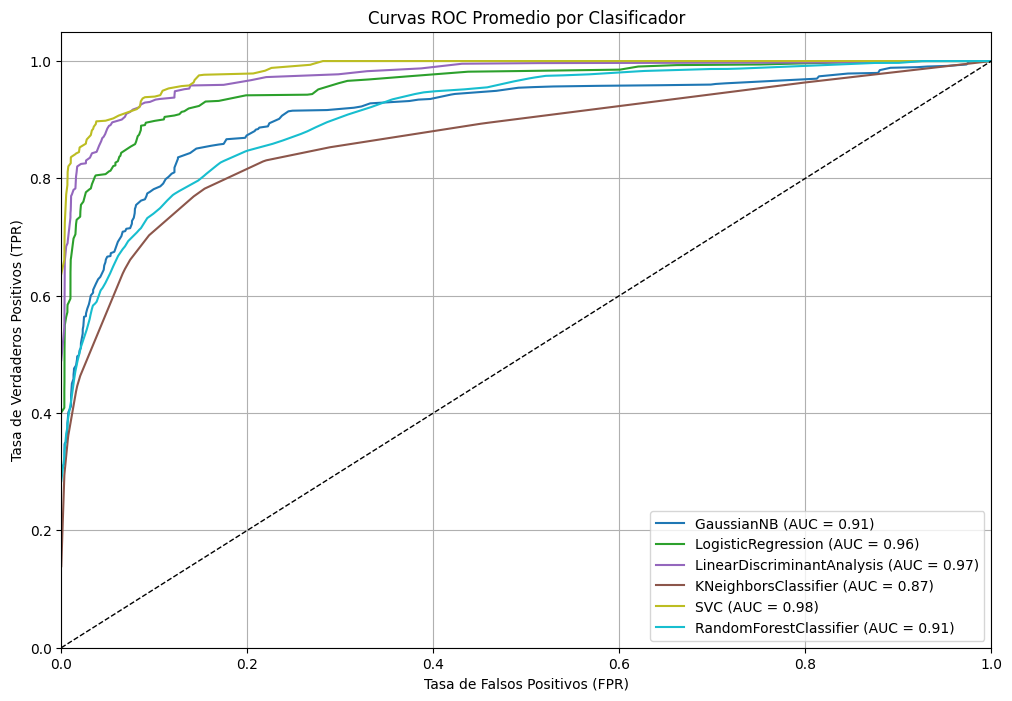

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import joblib  # Se añade esta importación para evitar el error

# Binarización de etiquetas
ytest_bin = label_binarize(ytest, classes=np.unique(y))
n_classes = ytest_bin.shape[1]

# Graficar curvas ROC promedio por modelo
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', len(models))

for idx, (name, (model, _)) in enumerate(models.items()):
    steps = [('scaler', scaler), ('pca', pca), (name.lower(), model)]
    pipe = Pipeline(steps)

    try:
        pipe.fit(Xtrain, ytrain)
        if not hasattr(pipe, 'predict_proba'):
            continue
        y_score = pipe.predict_proba(Xtest)
    except:
        continue  # Evita errores en modelos sin predict_proba

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {auc(all_fpr, mean_tpr):.2f})', color=colors(idx))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Promedio por Clasificador')
plt.legend(loc="lower right")
plt.grid()
plt.show()
